In [69]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns


# Import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from keras.src.applications.efficientnet import EfficientNetB0
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Sample TensorFlow operation to verify installation
a = tf.constant([1.0, 2.0, 3.0])
b = tf.constant([4.0, 5.0, 6.0])
c = a + b
print("TensorFlow operation result:", c.numpy())


TensorFlow version: 2.16.2
TensorFlow operation result: [5. 7. 9.]


In [55]:
directory_train = './Data/Train'
directory_validation = './Data/Val'
directory_test = './Data/Prediction'

In [56]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True
)

In [57]:
train_generator = gen.flow_from_directory(
    directory = directory_train,
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)


Found 288 images belonging to 2 classes.


In [58]:
validation_generator = gen.flow_from_directory(
    directory = directory_validation, # Use updated path
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 60 images belonging to 2 classes.


In [61]:
# Create a DataFrame for the test data
#The issue arises because the flow_from_directory method expects the data to be organized into subdirectories, where each subdirectory represents a class. Since your test directory does not have this structure, you need to use a different method to load the images for evaluation.
# You can use flow_from_dataframe or manually load and preprocess the images.
test_files = [os.path.join(directory_test, fname) for fname in os.listdir(directory_test)]
test_labels = ['Normal' if 'NORMAL' in fname else 'COVID-19' for fname in os.listdir(directory_test)]  # Adjust as necessary for your classes

test_df = pd.DataFrame({
    'filename': test_files,
    'class': test_labels
})

# Data generator using flow_from_dataframe
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(331, 331),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)


Found 23 validated image filenames belonging to 2 classes.


In [62]:

x, y = next(train_generator)
x.shape

(8, 331, 331, 3)

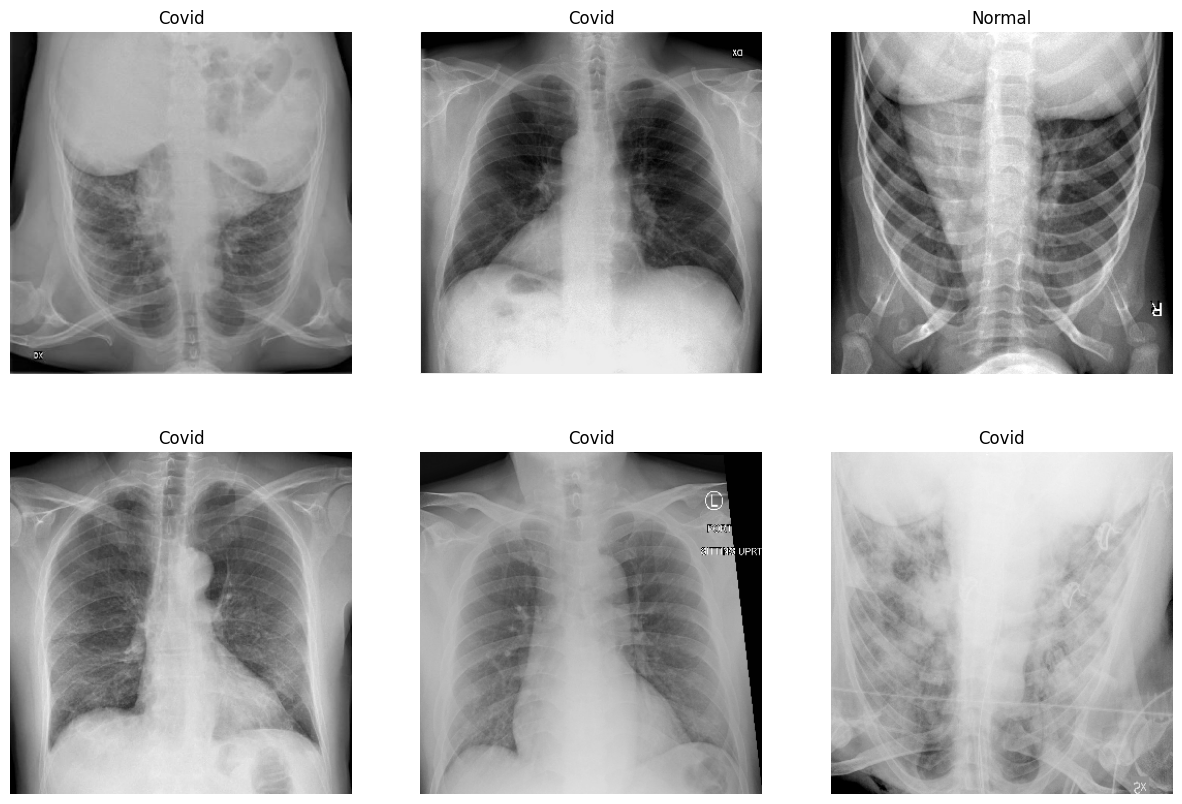

In [63]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

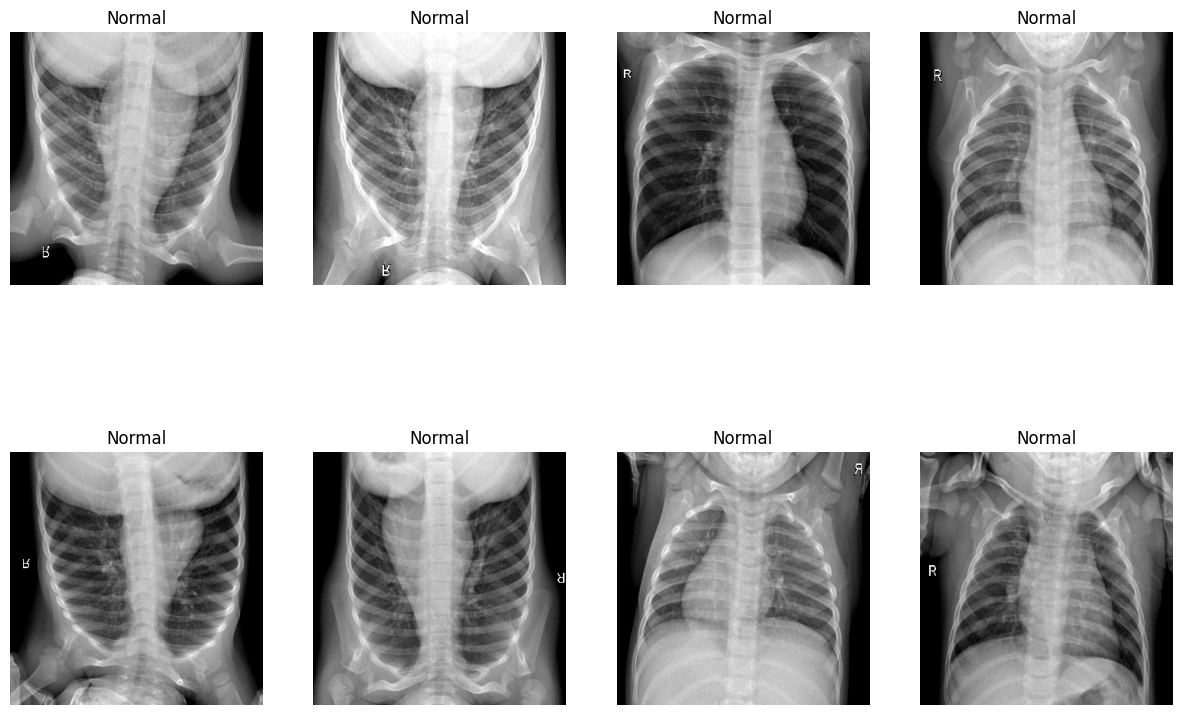

In [64]:
def extract_and_plot_normal_images(generator, num_images=8):
    normal_images = []
    normal_label = generator.class_indices['Normal']  # Get the index for 'Normal' class

    while len(normal_images) < num_images:
        images, labels = next(generator)
        for i in range(len(labels)):
            if np.argmax(labels[i]) == normal_label:
                normal_images.append(images[i])
                if len(normal_images) >= num_images:
                    break

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(normal_images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(normal_images[i])
        plt.title('Normal')
        plt.axis('off')
    plt.show()

# Call the function to extract and plot 8 normal images
extract_and_plot_normal_images(train_generator)

In [65]:
# Define the model
model = Sequential([
    EfficientNetB0(include_top=False, input_shape=(331, 331, 3)),
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.8635 - loss: 0.3464 - val_accuracy: 0.5000 - val_loss: 0.8466
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9720 - loss: 0.0643 - val_accuracy: 0.5000 - val_loss: 6.1439
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9726 - loss: 0.1030 - val_accuracy: 0.5000 - val_loss: 2.6985
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.9755 - loss: 0.0597 - val_accuracy: 0.5000 - val_loss: 2.0093
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9788 - loss: 0.0546 - val_accuracy: 0.5000 - val_loss: 1.4674
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.9886 - loss: 0.0425 - val_accuracy: 0.5000 - val_loss: 2.1575
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.9153 - loss: 0.5334 - val_accuracy: 0.5000 - val_loss: 3.6024
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.9952 - loss: 0.0117 - val_accuracy: 0.5000 - v

In [66]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.4891 - loss: 9.9285
Test Loss: 10.13666820526123, Test Accuracy: 0.47826087474823


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step


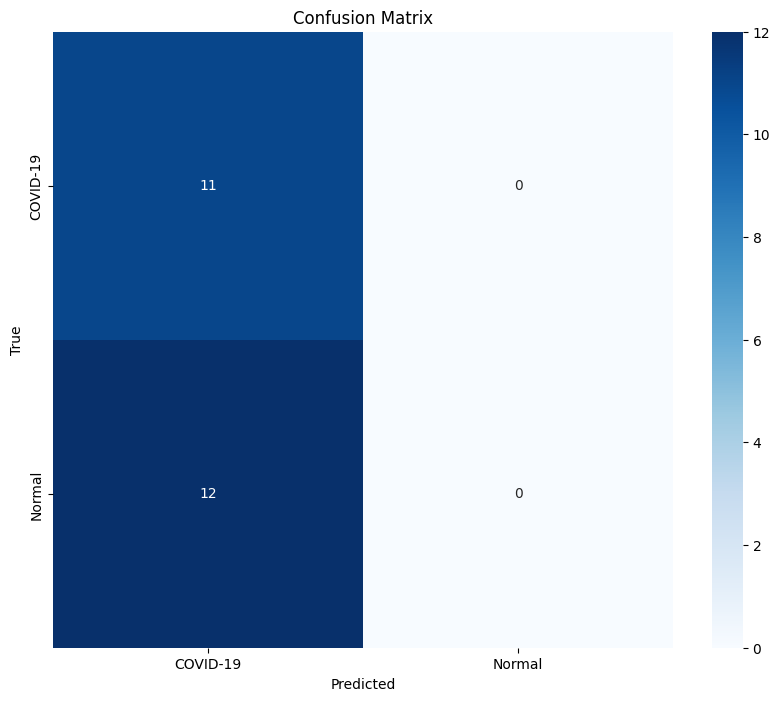

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print('Classification Report:')
print(class_report)

# Function to plot images with predictions
def plot_predicted_images(generator, model, num_images=8):
    images, labels = next(generator)
    predictions = model.predict(images)
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        true_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.48      1.00      0.65        11
      Normal       0.00      0.00      0.00        12

    accuracy                           0.48        23
   macro avg       0.24      0.50      0.32        23
weighted avg       0.23      0.48      0.31        23



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


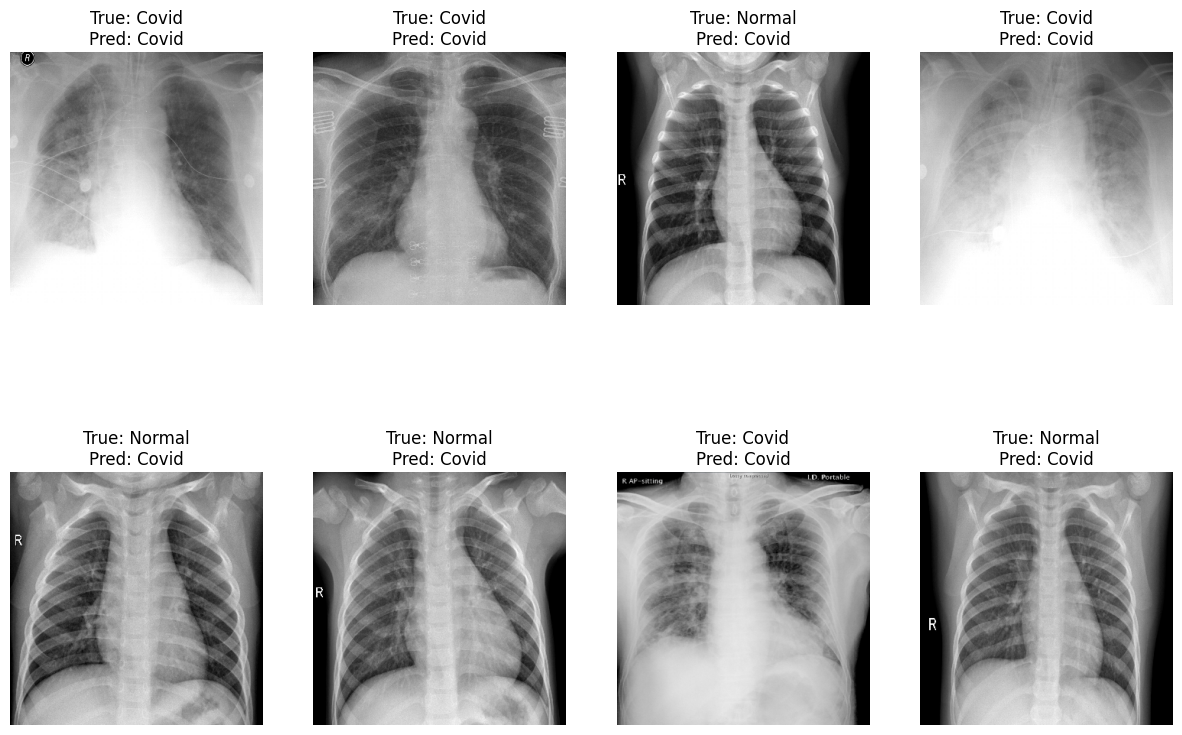

In [83]:
# Call the function to plot predicted images
plot_predicted_images(test_generator, model)

In [87]:
# Export our model to HDF5 file
model.save("covid_xray_model.h5")

In [89]:
# Load the model
model = tf.keras.models.load_model('covid_xray_model.h5')
# Optionally, verify the model by printing its summary
model.summary()

ValueError: Layer "dense_8" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 11, 11, 1280), dtype=float32, sparse=False, name=keras_tensor_3074>, <KerasTensor shape=(None, 11, 11, 1280), dtype=float32, sparse=False, name=keras_tensor_3075>]

In [73]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

ValueError: Layer "dense_8" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 11, 11, 1280), dtype=float32, sparse=False, name=keras_tensor_1535>, <KerasTensor shape=(None, 11, 11, 1280), dtype=float32, sparse=False, name=keras_tensor_1536>]